In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
DATASET_PATH = 'GTSRB/Train'
IMG_SIZE = 48
images = []
labels = []
for class_id in range(len(os.listdir(DATASET_PATH))):
    class_path = os.path.join(DATASET_PATH, str(class_id))
    for img_file in os.listdir(class_path):
        img = cv2.imread(os.path.join(class_path, img_file))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
        labels.append(class_id)

x = np.array(images)
y = np.array(labels)
print(x.shape, y.shape)        

(39209, 48, 48, 3) (39209,)


In [5]:
x = x.astype('float32')/255.0

num_classes = len(np.unique(y))
y_cat = utils.to_categorical(y, num_classes)

x_train, x_test, y_train, y_test = train_test_split(x, y_cat, test_size=0.2, random_state=42, stratify=y)
print(x_train.shape, x_test.shape)

(31367, 48, 48, 3) (7842, 48, 48, 3)


In [6]:
# 4. Custom CNN Model
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model_cnn = build_cnn(x_train.shape[1:], num_classes)
model_cnn.summary()


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,285,099 (4.90 MB)

 Trainable params: 1,284,651 (4.90 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_cnn.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=64, callbacks=[es], verbose=1)

Epoch 1/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 161s 393ms/step - accuracy: 0.7007 - loss: 1.0813 - val_accuracy: 0.5669 - val_loss: 1.7424
Epoch 2/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 197s 380ms/step - accuracy: 0.9610 - loss: 0.1244 - val_accuracy: 0.9820 - val_loss: 0.0548
Epoch 3/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 165s 285ms/step - accuracy: 0.9768 - loss: 0.0766 - val_accuracy: 0.9834 - val_loss: 0.0544
Epoch 4/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 110s 281ms/step - accuracy: 0.9815 - loss: 0.0593 - val_accuracy: 0.9872 - val_loss: 0.0494
Epoch 5/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 109s 278ms/step - accuracy: 0.9870 - loss: 0.0425 - val_accuracy: 0.9794 - val_loss: 0.0730
Epoch 6/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 109s 278ms/step - accuracy: 0.9857 - loss: 0.0503 - val_accuracy: 0.9863 - val_loss: 0.0556
Epoch 7/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 115s 293ms/step - accuracy: 0.9887 - loss: 0.0385 - val_accuracy: 0.9908 - val_loss: 0.0424
Epoch 8/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 141s 289ms/step - accuracy: 0.9929 -

In [8]:
test_loss, test_acc = model_cnn.evaluate(x_test, y_test, verbose=0)
print(f'{test_acc:.3f}')
y_pred = model_cnn.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

0.992
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        42
           1       0.99      1.00      0.99       444
           2       0.99      1.00      0.99       450
           3       0.99      1.00      0.99       282
           4       1.00      0.99      1.00       396
           5       0.99      0.99      0.99       372
           6       1.00      1.00      1.00        84
           7       0.99      0.99      0.99       288
           8       0.99      0.98      0.99       282
           9       1.00      1.00      1.00       294
          10       1.00      1.00      1.00       402
          11       1.00      0.99      0.99       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      1.00      1.00       156
          15       1.00      0.99      1.00       126
          16       1.00      1.00

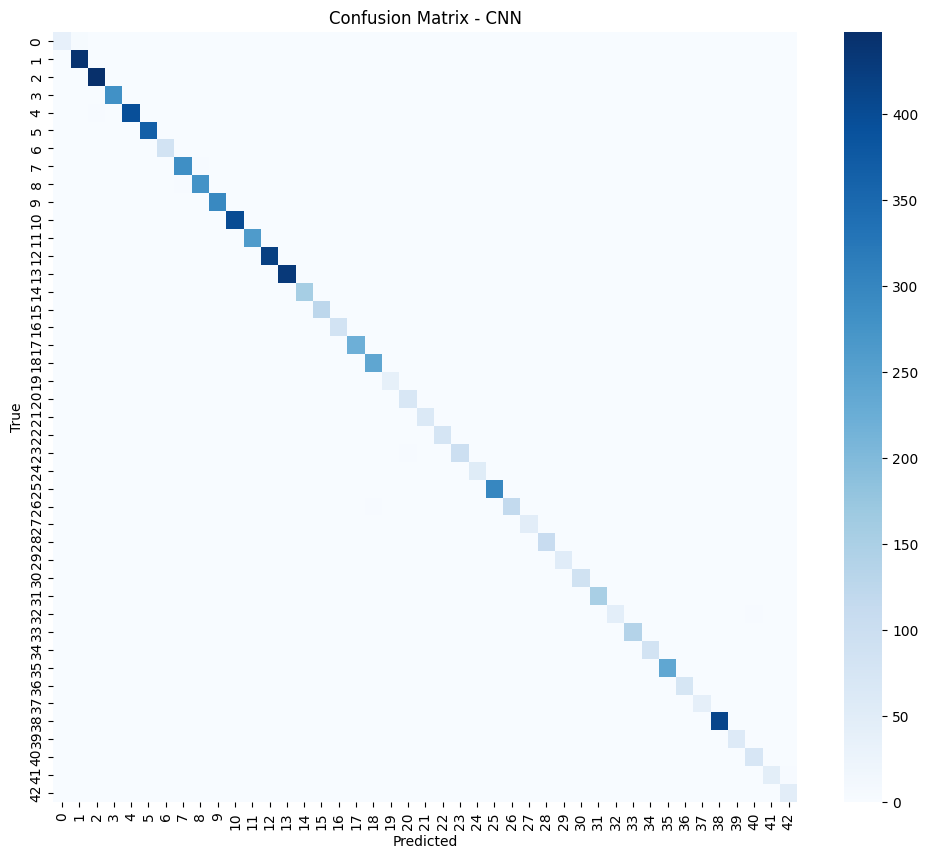

In [11]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN')
plt.show()

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Retrain with augmentation
history_aug = model_cnn.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_test, y_test),
    epochs=30,
    callbacks=[es],
    verbose=1
)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 173s 347ms/step - accuracy: 0.8897 - loss: 0.4470 - val_accuracy: 0.9922 - val_loss: 0.0270
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 132s 269ms/step - accuracy: 0.9571 - loss: 0.1462 - val_accuracy: 0.9950 - val_loss: 0.0188
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 129s 263ms/step - accuracy: 0.9730 - loss: 0.0983 - val_accuracy: 0.9972 - val_loss: 0.0086
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 130s 265ms/step - accuracy: 0.9789 - loss: 0.0747 - val_accuracy: 0.9981 - val_loss: 0.0089
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 130s 265ms/step - accuracy: 0.9789 - loss: 0.0762 - val_accuracy: 0.9926 - val_loss: 0.0236
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 153s 311ms/step - accuracy: 0.9801 - loss: 0.0702 - val_accuracy: 0.9969 - val_loss: 0.0104
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 136s 277ms/step - accuracy: 0.9839 - loss: 0.0582 - val_accuracy: 0.9971 - val_loss: 0.0096
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 141s 287ms/step - accuracy: 0.9821 -

In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Preprocess for MobileNet (resize to 96x96, 3 channels)
IMG_SIZE_TL = 96
X_resized = np.array([cv2.resize(img, (IMG_SIZE_TL, IMG_SIZE_TL)) for img in x])
X_resized = preprocess_input(X_resized)

X_train_tl, X_test_tl, y_train_tl, y_test_tl = train_test_split(
    X_resized, y_cat, test_size=0.2, random_state=42, stratify=y
)

# Load MobileNetV2 as base
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE_TL, IMG_SIZE_TL, 3))

for layer in base_model.layers:
    layer.trainable = False  # freeze

inputs = tf.keras.Input(shape=(IMG_SIZE_TL, IMG_SIZE_TL, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_tl = models.Model(inputs, outputs)
model_tl.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_tl.summary()

# Train
history_tl = model_tl.fit(
    X_train_tl, y_train_tl,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[es],
    verbose=1
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 58s 6us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,596,971 (9.91 MB)

 Trainable params: 338,987 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 168s 392ms/step - accuracy: 0.0540 - loss: 3.5472 - val_accuracy: 0.0542 - val_loss: 3.4995
Epoch 2/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 138s 351ms/step - accuracy: 0.0572 - loss: 3.5115 - val_accuracy: 0.0575 - val_loss: 3.4942
Epoch 3/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 134s 342ms/step - accuracy: 0.0550 - loss: 3.5033 - val_accuracy: 0.0523 - val_loss: 3.4878
Epoch 4/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 127s 324ms/step - accuracy: 0.0570 - loss: 3.5042 - val_accuracy: 0.0523 - val_loss: 3.4882
Epoch 5/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 125s 319ms/step - accuracy: 0.0570 - loss: 3.5020 - val_accuracy: 0.0542 - val_loss: 3.4953
